In [25]:
%matplotlib inline

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops
import label_map_util
import visualization_utils as vis_util

In [26]:
!curl -O http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.9M  100 72.9M    0     0   691k      0  0:01:48  0:01:48 --:--:--  398k


In [27]:
! tar zxvf ssd_mobilenet_v1_coco_2017_11_17.tar.gz

ssd_mobilenet_v1_coco_2017_11_17/
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.index
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.meta
ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_2017_11_17/saved_model/
ssd_mobilenet_v1_coco_2017_11_17/saved_model/saved_model.pb
ssd_mobilenet_v1_coco_2017_11_17/saved_model/variables/
ssd_mobilenet_v1_coco_2017_11_17/checkpoint


In [36]:
!python3 /home/bugra/.local/lib/python3.6/site-packages/tensorflow/python/tools/saved_model_cli.py show --dir ~/Eng/self/putting-tensorflow-models-to-production/notebooks/models/fashion_mnist/1 --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: Softmax/Softmax:0
  Method name is: tensorflow/serving/predict


In [28]:
!python3 /home/bugra/.local/lib/python3.6/site-packages/tensorflow/python/tools/saved_model_cli.py show --dir ~/Eng/self/putting-tensorflow-models-to-production/notebooks/ssd_mobilenet_v1_coco_2017_11_17/saved_model/ --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_UINT8
        shape: (-1, -1, -1, 3)
        name: image_tensor:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['detection_boxes'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 100, 4)
        name: detection_boxes:0
    outputs['detection_classes'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 100)
        name: detection_classes:0
    outputs['detection_scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 100)
        name: detection_scores:0
    outputs['num_detections'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: num_detections:0
  Method name is: tensorflow/serving/predict


In [29]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 6) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [31]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [32]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [33]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


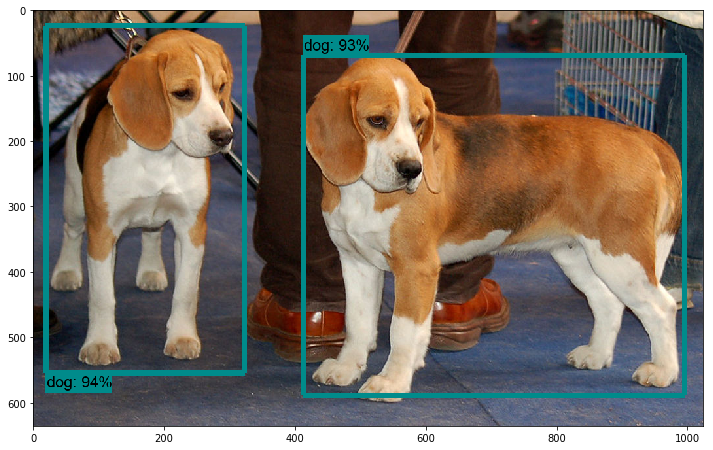

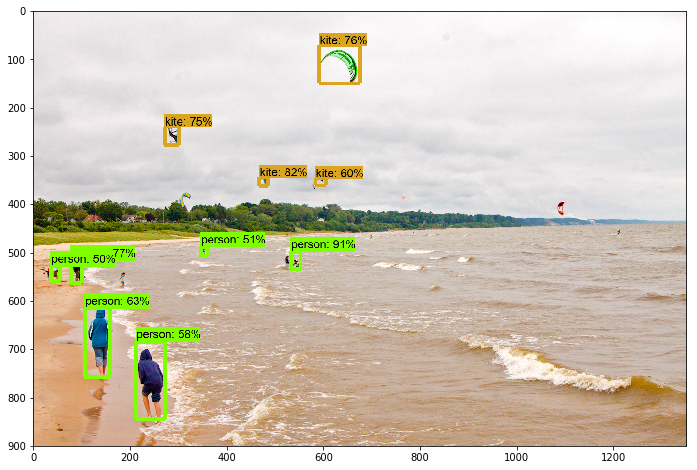

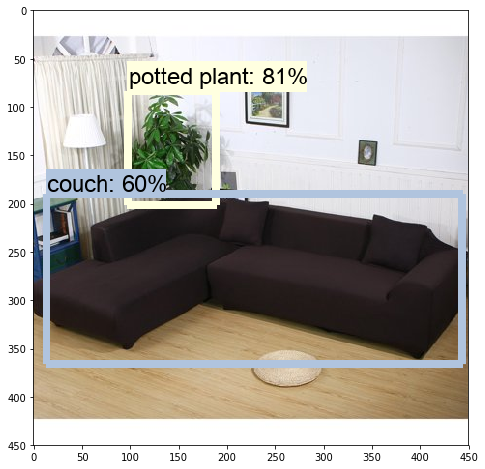

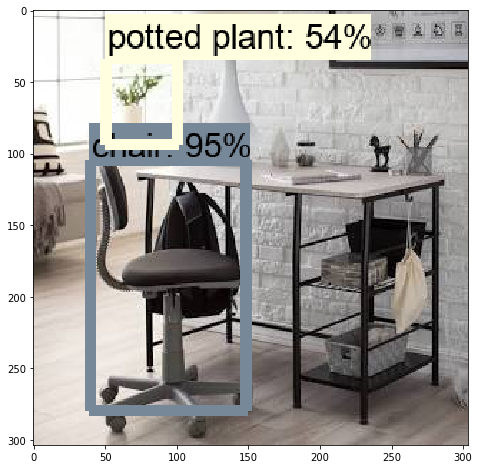

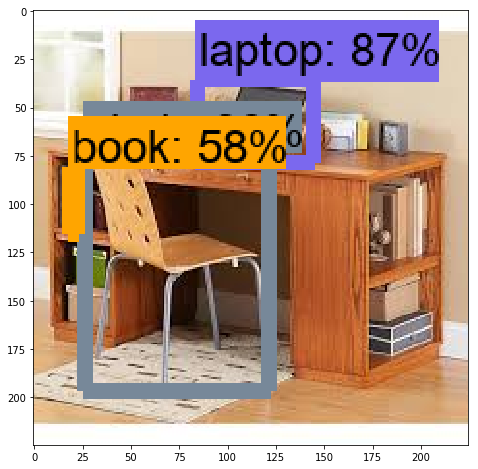

In [34]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

## REST API Example

In [9]:
import requests

In [14]:
STATUS_URL = 'http://localhost:8501/v1/models/coco'
METADATA_URL = 'http://localhost:8501/v1/models/coco/metadata'
PREDICTION_URL = 'http://localhost:8501/v1/models/coco:predict'
FIRST_VERSION_PREDICTION_URL = 'http://localhost:8501/v1/models/coco/versions/1:predict'
HEADERS = {"content-type": "application/json"}

In [17]:
requests.get(STATUS_URL).json()

{'model_version_status': [{'version': '1',
   'state': 'AVAILABLE',
   'status': {'error_code': 'OK', 'error_message': ''}}]}

In [16]:
# Metadata
requests.get(METADATA_URL).json()

{'model_spec': {'name': 'coco', 'signature_name': '', 'version': '1'},
 'metadata': {'signature_def': {'signature_def': {'serving_default': {'inputs': {'inputs': {'dtype': 'DT_UINT8',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '-1', 'name': ''},
         {'size': '-1', 'name': ''},
         {'size': '3', 'name': ''}],
        'unknown_rank': False},
       'name': 'image_tensor:0'}},
     'outputs': {'detection_classes': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '100', 'name': ''}],
        'unknown_rank': False},
       'name': 'detection_classes:0'},
      'num_detections': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''}],
        'unknown_rank': False},
       'name': 'num_detections:0'},
      'detection_boxes': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '100', 'name': ''},
         {'size': '4', 'name

In [18]:
json_response = requests.post(PREDICTION_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], test_labels[0], class_names[test_labels[0]], test_labels[0]))

NameError: name 'data' is not defined